# Chapter 5
## Section 2
Time based correlation analysis

In [1]:
#import packages
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt 
import folium
import datetime as dt
import os

In [2]:
%store -r c_co_out
%store -r c_co_in

## Temp - Check-outs correlation

## Daily transactions

In [3]:
#get the total check-outs in a day
#
ops=c_co_out.groupby(c_co_out['OwnerSince'].dt.date).size().to_frame('count')
ops['in']=c_co_in.groupby(c_co_in['OwnerTill'].dt.date).size()
print(ops.shape)



(837, 2)


In [4]:
ops.tail(3)

,count,in
OwnerSince,,
2022-03-02,377,478.0
2022-03-03,244,485.0
2022-03-04,78,362.0


In [5]:
# create a bin including empty days between the range of earliest and latest day that a transaction took place
bins=pd.date_range(start=pd.to_datetime(ops.index).min(), end=pd.to_datetime(ops.index).max())
bins=pd.to_datetime(bins)
bins=pd.Series(bins).dt.date
bins=pd.DataFrame(bins, columns=['date'])


# add this bin as an index into df with merge operation
# now, we have all days in the df
ops['date']=pd.to_datetime(ops.index)
ops['date']=ops['date'].dt.date
ops.index=ops['date']

ops=pd.merge(bins,ops, how='left', left_on=bins['date'], \
                 right_index=True).fillna(0).drop(['date_y'], axis=1).rename(columns={'date_x':'date'}).set_index('date')
print(ops.shape)

(894, 2)


## Temp data

https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/recent/DESCRIPTION_obsgermany_climate_daily_kl_recent_en.pdf
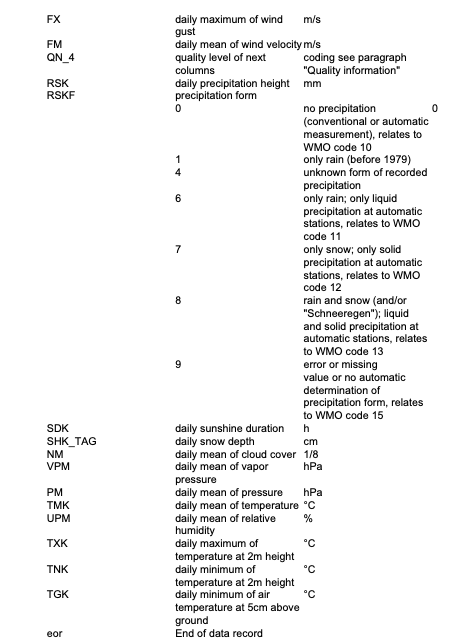

In [7]:
## Temp
temp1=pd.read_csv('../data/generated/DWD/daily/kl/historical/ts_merged.csv',sep=';').drop('Unnamed: 0', axis=1).set_index(['stations_id','mess_datum'])
temp2=pd.read_csv('../data/generated/DWD/daily/kl/recent/ts_merged.csv',sep=';').drop('Unnamed: 0', axis=1).set_index(['stations_id','mess_datum'])


temp=pd.concat([temp1,temp2])
temp.head()



temp.index.is_unique

temp=temp.drop_duplicates(keep='last')

temp=temp.reset_index().groupby('mess_datum').mean().reset_index()# take the mean of values of the weather stations in Köln region

temp['mess_datum']=pd.to_datetime(temp['mess_datum']).dt.date
temp.drop('stations_id', axis=1, inplace=True)
temp.index=temp['mess_datum']
print(temp.shape)
#temp.tail()

# create a bin including empty days between the range of earliest and latest day that a transaction took place
bins=pd.date_range(start=pd.to_datetime(temp.index).min(), end=pd.to_datetime(temp.index).max())
bins=pd.to_datetime(bins)
bins=pd.Series(bins).dt.date
bins=pd.DataFrame(bins, columns=['date'])
temp=bins.join(temp,how='left', on='date').set_index('date')
print(temp.shape)

(1076, 17)
(1076, 17)


In [8]:
# merge with weather data
ops=pd.merge(ops,temp, left_index=True, right_on=temp['mess_datum'], how='left').set_index('key_0')
ops.index.rename('Date', inplace=True)
print(ops.shape)
ops.head()

(894, 19)


,count,in,mess_datum,qn_3,fx,fm,qn_4,rsk,rskf,sdk,shk_tag,nm,vpm,pm,tmk,upm,txk,tnk,tgk
Date,,,,,,,,,,,,,,,,,,,
2019-09-23,62.0,1.0,2019-09-23,-494.5,-495.90,-498.50,3.0,0.10,3.0,-499.2415,-499.5,-496.25,15.10,2.075,16.25,82.520,20.50,12.80,11.40
2019-09-24,13.0,1.0,2019-09-24,-494.5,-495.15,-497.80,3.0,2.70,5.0,-498.6250,-499.5,-496.35,13.55,0.035,15.20,79.645,20.15,10.80,9.15
2019-09-25,21.0,8.0,2019-09-25,-494.5,-493.95,-497.95,3.0,0.40,5.0,-498.2915,-499.5,-495.85,14.55,-1.885,16.00,80.810,19.70,13.15,11.85
2019-09-26,19.0,9.0,2019-09-26,-494.5,-495.40,-497.90,3.0,8.60,5.0,-499.5000,-499.5,-495.60,16.80,-0.520,16.50,89.060,18.25,14.05,13.05
2019-09-27,15.0,11.0,2019-09-27,-494.5,-493.65,-497.65,3.0,0.05,3.0,-497.0585,-499.5,-496.65,14.00,-0.340,16.40,76.500,21.60,13.30,11.95


In [9]:
#ops[ops['count']<1]

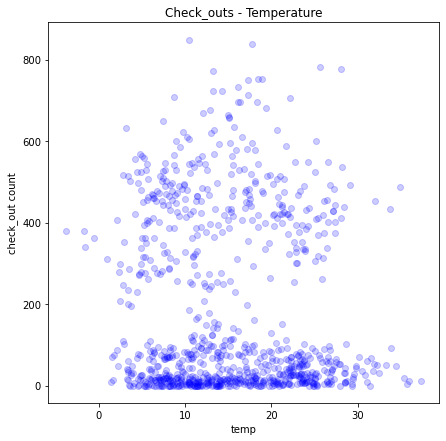

In [10]:
plt.figure(figsize=(7, 7))
plt.title('Check_outs - Temperature')

y = ops['count']
x = ops['txk']


plt.scatter(x, y,  c="b", alpha=0.2)
plt.ylabel("check_out count")
plt.xlabel("temp")
#plt.legend(loc='upper left')
plt.show()


In [11]:
ops[['count','sdk','txk','nm']].corr().head(1) # correlations
#sdk: daily sunshine duration
# txk: daily max temp 
# nm: daily mean cloud cover

,count,sdk,txk,nm
count,1.0,0.229581,-0.082906,0.230086


## Corona Cases & Checkout Correlation

### Corona Data
https://github.com/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland 
<br> Same data can be seen on https://experience.arcgis.com/experience/478220a4c454480e823b17327b2bf1d4 
<br> filter data with NRW/Köln and look at the graph of Covid-19-Fälle/Tag nach Meldedatum with Zuvorgemeldet filter option. 

In [13]:
df=pd.read_csv('../data/Aktuell_Deutschland_SarsCov2_Infektionen.csv')
df['Meldedatum']= pd.to_datetime(df['Meldedatum'])
df['Refdatum']= pd.to_datetime(df['Refdatum'])



cdf=df[(df['IdLandkreis']==5315)].groupby(df['Meldedatum'].dt.date)['AnzahlFall'].sum().to_frame('corona')



# join with ops transactional data
ops=ops.join(cdf, how='left')#.drop('key_0', axis=1)

ops.tail(100).head()

,count,in,mess_datum,qn_3,fx,fm,qn_4,rsk,rskf,sdk,shk_tag,nm,vpm,pm,tmk,upm,txk,tnk,tgk,corona
Date,,,,,,,,,,,,,,,,,,,,
2021-11-25,544.0,460.0,2021-11-25,-328.666667,-329.666667,-332.000000,3.0,0.400000,5.333333,-331.488667,-333.0,-328.133333,6.700000,333.566667,3.266667,87.016667,5.633333,0.533333,-0.566667,322.0
2021-11-26,406.0,402.0,2021-11-26,-328.666667,-325.133333,-330.333333,3.0,3.933333,5.333333,-333.000000,-333.0,-327.733333,6.966667,323.853333,4.500000,82.776667,5.600000,3.566667,2.900000,716.0
2021-11-27,88.0,103.0,2021-11-27,-328.666667,-327.733333,-330.933333,3.0,0.000000,0.000000,-331.078000,-333.0,-329.533333,6.166667,319.253333,3.366667,79.303333,6.266667,0.900000,-1.933333,623.0
2021-11-28,68.0,42.0,2021-11-28,-328.666667,-327.600000,-331.466667,3.0,0.000000,4.000000,-333.000000,-333.0,-328.200000,6.466667,324.233333,2.900000,86.030000,4.466667,1.666667,0.300000,685.0
2021-11-29,556.0,389.0,2021-11-29,-328.666667,-326.466667,-330.933333,3.0,5.933333,6.666667,-333.000000,-333.0,-328.466667,6.633333,331.200000,2.266667,92.193333,4.233333,-1.100000,-3.200000,784.0


In [14]:
# plot 7_day_incidence 
for i,row in ops.iterrows():
    ops.loc[i,'7_day']=ops[:i].tail(7)['corona'].mean()

ops.tail()


,count,in,mess_datum,qn_3,fx,fm,qn_4,rsk,rskf,sdk,...,nm,vpm,pm,tmk,upm,txk,tnk,tgk,corona,7_day
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-28,123.0,172.0,2022-02-28,-498.0,-493.85,-497.55,3.0,0.0,0.0,-494.5750,...,-499.40,4.70,9.965,5.60,53.565,11.00,-2.00,-4.85,1620.0,1670.000000
2022-03-01,417.0,453.0,2022-03-01,-498.0,-494.85,-497.60,3.0,0.0,0.0,-497.8000,...,-496.80,4.25,8.860,5.25,48.880,9.35,1.85,-1.55,3028.0,1782.285714
2022-03-02,377.0,478.0,2022-03-02,-498.0,-496.15,-498.20,3.0,0.0,0.0,-495.2085,...,-497.75,3.85,6.225,6.10,42.980,12.40,0.90,-1.90,3821.0,1996.000000
2022-03-03,244.0,485.0,2022-03-03,-498.0,-495.65,-498.05,3.0,0.0,0.0,-494.8165,...,-499.35,3.95,4.010,5.45,46.580,12.95,-1.75,-5.00,6851.0,2724.714286
2022-03-04,78.0,362.0,2022-03-04,-498.0,-496.25,-498.25,3.0,0.0,0.0,-494.4335,...,-499.50,4.20,4.815,4.45,52.395,11.30,-2.85,-5.65,4985.0,3173.000000


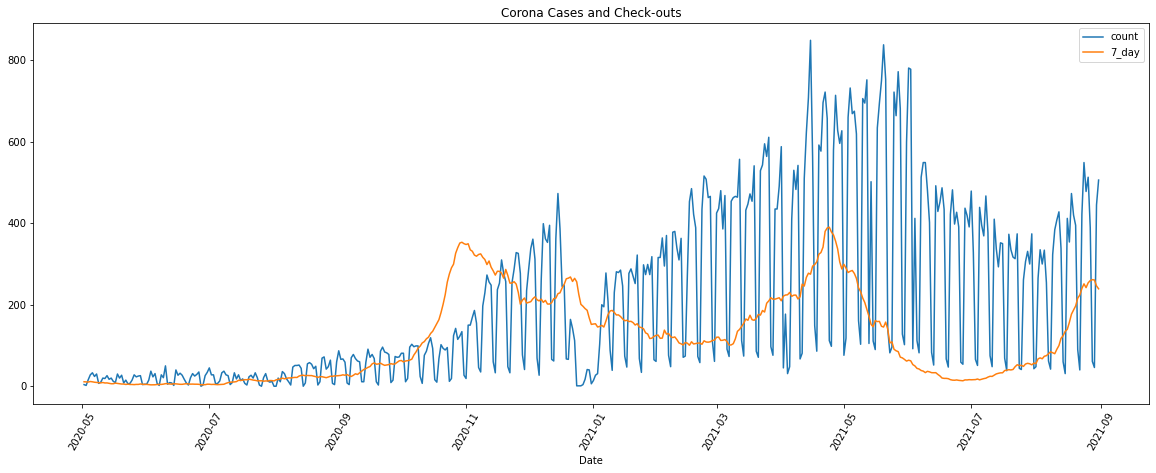

In [15]:
# Since, by 2022, the politicians do not react harshly anymore in terms of counter-restrictions,
# I decided to take into account data up to this date. 
start_date=dt.datetime(2020, 5, 1).date()
end_date=dt.datetime(2021, 9, 1).date()



ops[(ops.index<end_date) &(ops.index>start_date) ][['count','7_day']].plot(figsize=(20,7) )
plt.xticks(rotation=60)
plt.title('Corona Cases and Check-outs')
plt.show()

### Lockdown dates
https://www.wiwo.de/politik/deutschland/corona-lockdown-so-ist-der-zweite-lockdown-in-deutschland-verlaufen/27076474.html <br>
https://www.wiwo.de/politik/deutschland/corona-wie-verlief-der-erste-lockdown-in-deutschland/26853384.html
<br>
Bundesweit 22 March 2020 - 15 June 2020 <br>

Bundesweit Lockdown:  02 Nov 2020 - 31 May  2021 (7 Monate) <br>

After 1.Oct 2021 Restaurants are fully opened. <br>

https://www.ndr.de/nachrichten/info/Corona-Chronologie-Die-Ereignisse-im-Norden,coronachronologieindex100.html <br>
https://www.ndr.de/nachrichten/info/Chronologie-zur-Corona-Krise-in-Norddeutschland,coronachronologie114.html <br>
https://www.ndr.de/nachrichten/info/Chronologie-zur-Corona-Krise-in-Norddeutschland,coronachronologie116.html <br>

https://www.mdr.de/nachrichten/jahresrueckblick/corona-chronik-chronologie-coronavirus-102.html#sprung2 <br>
 

 
13 March- 19 April 2020 is the first Lockdown. Almost every store was closed. <br> 
https://de.wikipedia.org/wiki/COVID-19-Pandemie_in_Nordrhein-Westfalen#M%C3%A4rz_2020 <br>
https://www1.wdr.de/nachrichten/themen/coronavirus/ticker-archiv-corona-virus-nrw-mai-100.html <br>
 


In [16]:
from scipy.stats import pearsonr
df=ops[(ops.index>start_date) & (ops.index<end_date)][['count','7_day']]
y=df['count']
x=df['7_day']
pearsonr(x,y) # corr and p_value

(0.36354785654475413, 1.1571144582243916e-16)

In [17]:
import statsmodels.api as sm
mod = sm.OLS(y,sm.add_constant(x))
fii = mod.fit()


fii.summary()#R-squared explains the proportaion of the variance explained by the model. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     73.86
Date:                Wed, 13 Jul 2022   Prob (F-statistic):           1.16e-16
Time:                        13:29:15   Log-Likelihood:                -3266.5
No. Observations:                 487   AIC:                             6537.
Df Residuals:                     485   BIC:                             6545.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        117.7993     13.539      8.701      0.000      91.197     144.401
7_day          0.7450      0.087      8.594      0.000       0.575       0.915
==============================================================================
Omnibus:                       46.085   Durbin-Watson:                   0.685
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.894
Skew:                           0.843   Prob(JB):                     2.68e-13
Kurtosis:                       2.911   Cond. No.                         235.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=True).fit(np.array(x).reshape(-1, 1), np.array(y).reshape(-1, 1))
prediction=reg.predict(np.array(x).reshape(-1, 1))

df['res']=(np.array(y).reshape(-1, 1)-prediction)
df['pred_']=prediction

print('intercept:',reg.intercept_)
print('Coeff:', reg.coef_)
print('R-squared :',reg.score(np.array(x).reshape(-1, 1), np.array(y).reshape(-1, 1)))
#R-squared explains the proportaion of the variance explained by the model. 

intercept: [117.79926452]
Coeff: [[0.7449627]]
R-squared : 0.13216704399828516


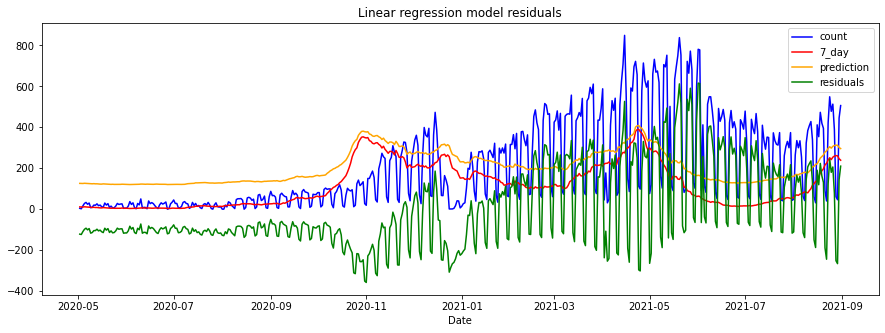

In [19]:
# plot
(df['res']+df['pred_']).plot(color='blue', label='count', figsize=(15,5))
#(df['count']- df['res']).plot(color='cyan', label='count-residual')
df['7_day'].plot(color='red', label='7_day')

df['pred_'].plot(color='orange', label='prediction')
df['res'].plot(color='green', label='residuals')
plt.title('Linear regression model residuals')
plt.legend()
plt.show()

In [20]:
ops['7_day_r']=ops[(ops.index>start_date) & (ops.index<end_date)]['7_day']


In [21]:
ops.loc[(ops.index<start_date) | (ops.index>end_date), '7_day_r']=None

In [22]:
ops.tail()

,count,in,mess_datum,qn_3,fx,fm,qn_4,rsk,rskf,sdk,...,vpm,pm,tmk,upm,txk,tnk,tgk,corona,7_day,7_day_r
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-28,123.0,172.0,2022-02-28,-498.0,-493.85,-497.55,3.0,0.0,0.0,-494.5750,...,4.70,9.965,5.60,53.565,11.00,-2.00,-4.85,1620.0,1670.000000,NaN
2022-03-01,417.0,453.0,2022-03-01,-498.0,-494.85,-497.60,3.0,0.0,0.0,-497.8000,...,4.25,8.860,5.25,48.880,9.35,1.85,-1.55,3028.0,1782.285714,NaN
2022-03-02,377.0,478.0,2022-03-02,-498.0,-496.15,-498.20,3.0,0.0,0.0,-495.2085,...,3.85,6.225,6.10,42.980,12.40,0.90,-1.90,3821.0,1996.000000,NaN
2022-03-03,244.0,485.0,2022-03-03,-498.0,-495.65,-498.05,3.0,0.0,0.0,-494.8165,...,3.95,4.010,5.45,46.580,12.95,-1.75,-5.00,6851.0,2724.714286,NaN
2022-03-04,78.0,362.0,2022-03-04,-498.0,-496.25,-498.25,3.0,0.0,0.0,-494.4335,...,4.20,4.815,4.45,52.395,11.30,-2.85,-5.65,4985.0,3173.000000,NaN


## Casuality test between check-outs and check-ins
See https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.grangercausalitytests.html<br>
https://www.statology.org/granger-causality-test-in-python/

 <br>
Null Hypothesis (H0): Time series x does not Granger-cause time series y <br>

Alternative Hypothesis (HA): Time series x Granger-causes time series y


<AxesSubplot:xlabel='Date'>

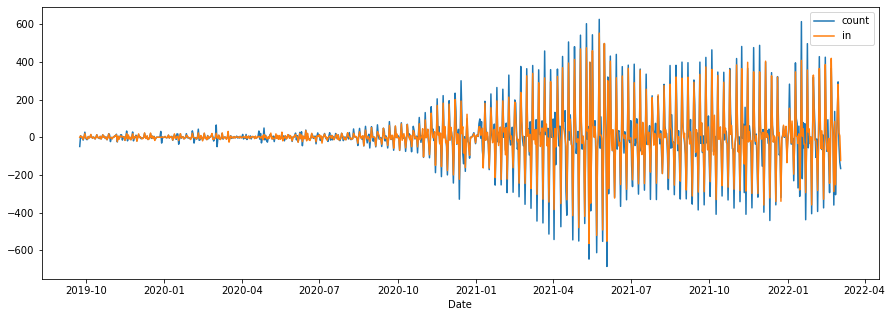

In [23]:

x=ops['count'].diff()[1:]
y=ops['in'].diff()[1:]
#perform Granger-Causality test


pd.DataFrame([x,y]).T.plot(figsize=(15,5))

In [24]:
from statsmodels.tsa.stattools import adfuller
result=adfuller(x)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for k,v in result[4].items():
    print(k,v)

ADF Statistic: -9.154538
p-value: 0.000000
Critical Values:
1% -3.4378713927343156
5% -2.8648601928465505
10% -2.568537914369582


In [25]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(pd.DataFrame([x,y]).T, maxlag=[1])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4919  , p=0.4833  , df_denom=889, df_num=1
ssr based chi2 test:   chi2=0.4935  , p=0.4824  , df=1
likelihood ratio test: chi2=0.4934  , p=0.4824  , df=1
parameter F test:         F=0.4919  , p=0.4833  , df_denom=889, df_num=1


{1: ({'ssr_ftest': (0.49187726455914865, 0.48327463545757665, 889.0, 1),
   'ssr_chi2test': (0.49353714284225036, 0.4823536945436846, 1),
   'lrtest': (0.4934006579187553, 0.48241425783152003, 1),
   'params_ftest': (0.49187726455910885, 0.48327463545757665, 889.0, 1.0)},
   array([[0., 1., 0.]])])}

In [26]:
grangercausalitytests(pd.DataFrame([y,x]).T, maxlag=[1])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5358  , p=0.0062  , df_denom=889, df_num=1
ssr based chi2 test:   chi2=7.5612  , p=0.0060  , df=1
likelihood ratio test: chi2=7.5294  , p=0.0061  , df=1
parameter F test:         F=7.5358  , p=0.0062  , df_denom=889, df_num=1


{1: ({'ssr_ftest': (7.53581870138542, 0.006170440179698854, 889.0, 1),
   'ssr_chi2test': (7.5612489107264285, 0.005963664974973037, 1),
   'lrtest': (7.529381514650595, 0.006070074284142302, 1),
   'params_ftest': (7.535818701385376, 0.006170440179699166, 889.0, 1.0)},
   array([[0., 1., 0.]])])}